In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import roc_curve
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch.nn as nn

class ASSIST(nn.Module):
    def __init__(self):
        super(ASSIST, self).__init__()
        
        # define the convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # define the fully connected layers
        self.fc1 = nn.Linear(in_features=80000, out_features=128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=128, out_features=2)
        
    def forward(self, x):
        # apply the convolutional layers
        x = x.view(x.shape[0],1, x.shape[1])

        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.functional.relu(x)
        x = self.pool3(x)
        
        # reshape the output of the convolutional layers
        x = x.view(x.size(0), -1)
        
        # apply the fully connected layers
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [4]:
path = '/content/drive/MyDrive/DAI/Spoof Detection/'
os.listdir(path)

['Audio_english', 'TTS_english']

In [5]:
class AudioDataset(Dataset):
    def __init__(self, real_audio_dir, fake_audio_dir):
        self.real_audio_dir = real_audio_dir
        self.fake_audio_dir = fake_audio_dir
        self.real_audio_files = os.listdir(self.real_audio_dir)
        self.fake_audio_files = os.listdir(self.fake_audio_dir)
        self.sample_rate = 16000 # sample rate for all audio files
        
    def __len__(self):
        return len(self.real_audio_files) + len(self.fake_audio_files)
    
    def __getitem__(self, idx):
        if idx < len(self.real_audio_files):
            audio_file = self.real_audio_files[idx]
            label = 0 # 0 for real audio
            audio_path = os.path.join(self.real_audio_dir, audio_file)
        else:
            audio_file = self.fake_audio_files[idx - len(self.real_audio_files)]
            label = 1 # 1 for fake audio
            audio_path = os.path.join(self.fake_audio_dir, audio_file)
        
        waveform, sr = librosa.load(audio_path, sr=self.sample_rate)
        waveform = torch.from_numpy(waveform).float()
        waveform_length = waveform.shape[0]
        
        # pad or truncate the waveform to have the same length
        target_length = self.sample_rate * 5 # 5 seconds
        if waveform_length < target_length:
            num_missing_samples = target_length - waveform_length
            padding = torch.zeros(num_missing_samples)
            waveform = torch.cat((waveform, padding))
        else:
            waveform = waveform[:target_length]
        
        return waveform, label
            
# Define the data loaders
dataset = AudioDataset(path+'Audio_english', path+'TTS_english')
#test_dataset = AudioDataset('path/to/testing/data')

print(len(dataset))

train_dataset,test_dataset = torch.utils.data.dataset.random_split(dataset,[650,137])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

787


In [7]:
a = iter(test_loader)
b = next(a)
print(b[0].shape)
print(b[1])

torch.Size([32, 80000])
tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0])


In [8]:
def train(model, train_loader, test_loader, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            train_acc += pred.eq(label.view_as(pred)).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)
        
        model.eval()
        test_loss = 0
        test_acc = 0
        
        with torch.no_grad():
            for data, label in test_loader:
                data = data.to(device)
                label = label.to(device)
                output = model(data)
                loss = criterion(output, label)
                test_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                test_acc += pred.eq(label.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader.dataset)
        test_acc /= len(test_loader.dataset)
        
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_acc:.4f}, Test Loss = {test_loss:.4f}, Test Accuracy = {test_acc:.4f}")

# Train the model
model = ASSIST()
train(model, train_loader, test_loader, num_epochs=5)

Epoch 1: Train Loss = 0.0553, Train Accuracy = 0.8754, Test Loss = 0.0516, Test Accuracy = 0.3723
Epoch 2: Train Loss = 0.0031, Train Accuracy = 0.9923, Test Loss = 0.2226, Test Accuracy = 0.6496
Epoch 3: Train Loss = 0.0027, Train Accuracy = 0.9892, Test Loss = 0.1240, Test Accuracy = 0.7445
Epoch 4: Train Loss = 0.0062, Train Accuracy = 0.9923, Test Loss = 0.0026, Test Accuracy = 0.9854
Epoch 5: Train Loss = 0.0030, Train Accuracy = 0.9923, Test Loss = 0.0007, Test Accuracy = 0.9854


# To check on Pretrained AASIST model

In [ ]:
!git clone 'https://github.com/clovaai/aasist'

Cloning into 'aasist'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 38 (delta 3), reused 3 (delta 3), pack-reused 32
Unpacking objects: 100% (38/38), 1.43 MiB | 10.93 MiB/s, done.


In [ ]:
%cd aasist
!pip install -r requirements.txt

/content/aasist
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-py3-none-any.whl size=7532 sha256=e3c85e62be4ab4fd78dd4522ab83352d60a79ddbcd35644d469f0a4f0fcae400
  Stored in directory: /root/.cache/pip/wheels/3b/75/17/b11b16ad90276ff6e4e03ec375d55291a186c7fe9dbf87fba3
Successfully built torchcontrib


In [9]:
# Removed unnecessary content from the main.py file.
# After making the required changes in main.py file and config files

!python main.py --eval --config ./config/AASIST.conf

Epoch 1: Train Loss = 0.0603, Train Accuracy = 0.8369, Test Loss = 0.2511, Test Accuracy = 0.6496
Epoch 2: Train Loss = 0.0114, Train Accuracy = 0.9723, Test Loss = 0.1595, Test Accuracy = 0.6642
Epoch 3: Train Loss = 0.0059, Train Accuracy = 0.9785, Test Loss = 0.0354, Test Accuracy = 0.8978


In [12]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def evaluation(model,test_dl):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    preds = []
    pred_labels = []
    labels = []

            # Disable gradient calculation for validation or inference using torch.no_rad()
    with torch.no_grad():
        for x,y in test_dl:
            x = x.to(device)
            y = y.to(device) #CHW --> #HWC
            valid_logits = model(x)
            predict_prob = F.softmax(valid_logits)
            _,predictions = predict_prob.max(1)
            predictions = predictions.to('cpu')

            _, valid_preds = torch.max(valid_logits, 1)
            valid_loss = criterion(valid_logits,y)
            running_loss += valid_loss.item() * x.size(0)
            running_corrects += torch.sum(valid_preds == y.data)
            total += y.size(0)
            predict_prob = predict_prob.to('cpu')

            pred_labels.extend(list(predictions.numpy()))
            preds.extend(list(predict_prob.numpy()))
            y = y.to('cpu')
            labels.extend(list(y.numpy()))

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)
    print("Test Loss is {}".format(epoch_loss))
    print("Test Accuracy is {}".format(epoch_acc.cpu()))
    return np.array(labels),np.array(pred_labels),np.array(preds)

def calculate_eer(y_test, y_pred):
    # Calculate the false positive rate (fpr) and true positive rate (tpr)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    # Find the threshold index closest to the point where fpr = 1 - tpr
    fnr = 1 - tpr
    eer_threshold_idx = np.argmin(np.abs(fnr - fpr))
    
    # Calculate EER as the average of the two closest points to the threshold
    eer = (fpr[eer_threshold_idx] + fnr[eer_threshold_idx]) / 2
    
    return eer

In [79]:
import copy
def roc_det(y_true,y_pred):
    metrics = {'fpr':[],'tpr':[],'fnr':[]}
    for i in np.arange(0,1.2,0.001):
        new_y = copy.deepcopy(y_pred)
        y_pred_new = (new_y > i)
        fp = ((y_true == 0) & (y_pred_new == 1)).sum()
        tp = ((y_true == 1) & (y_pred_new == 1)).sum()
        fn = ((y_true == 1) & (y_pred_new == 0)).sum()
        tn = ((y_true == 0) & (y_pred_new == 0)).sum()
        metrics['fpr'].append(fp/(fp+tn))
        metrics['tpr'].append(tp/(tp+fn))
        metrics['fnr'].append(fn/(fn+tp))
    return metrics

In [16]:
labels1, pred_labels1, preds1 = evaluation(model,test_loader)
print('EER:', calculate_eer(labels1, pred_labels1))

Test Loss is 0.02127577176608164
Test Accuracy is 0.9854014598540146
EER: 0.016034644194756573


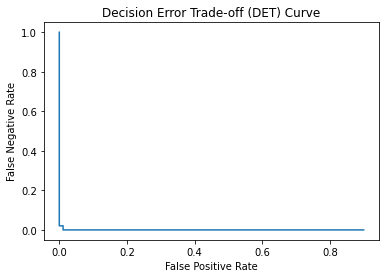

In [84]:
metrics1 = roc_det(labels1,preds1[:,1])
plt.plot(metrics1['fpr'],metrics1['fnr'])
plt.title('Decision Error Trade-off (DET) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
plt.show()

In [14]:
# model2 corresponds to the AASIST model
labels, pred_labels, preds = evaluation(model2,test_loader)
print('EER:', calculate_eer(labels, pred_labels))

<ipython-input-12-67af477b36a1>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict_prob = F.softmax(valid_logits)


Test Loss is 0.9082689537619152
Test Accuracy is 0.8978102189781022
EER: 0.14583333333333331


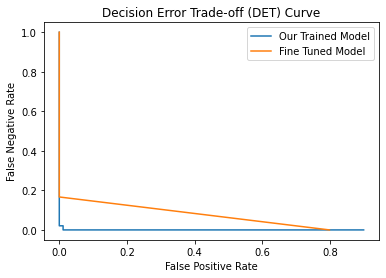

In [83]:
metrics = roc_det(labels,preds[:,1])
plt.plot(metrics1['fpr'],metrics1['fnr'], label = 'Our Trained Model')
plt.plot(metrics['fpr'],metrics['fnr'], label = 'Fine Tuned Model')
plt.legend()
plt.title('Decision Error Trade-off (DET) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
plt.show()